# Linus lines analysis — Linux 3.0 / 4.15 / 5.10 / 6.18

Этот ноутбук берет CSV (по одной версии) и считает метрики из пунктов **1–3**:
1. **Масштаб присутствия** (кол-во файлов, суммарные строки Линуса, кол-во подсистем)  
2. **Распределение по подсистемам** (сумма `linus_lines` и число файлов по верхнему каталогу)  
3. **Распределение по типам файлов** (по расширениям и спец-файлам Makefile/Kconfig)

В конце — **сравнение версий** и короткий **итог**


In [1]:
import pandas as pd
from pathlib import Path

DATASETS = {
    "3.0":  "linus_3_0.csv",
    "4.15": "linus_4_15.csv",
    "5.10": "linus_5_10.csv",
    "6.18": "linus_6_18.csv",
}

def read_version_csv(version: str, filename: str) -> pd.DataFrame:
    p = Path(filename)
    if not p.exists():
        p = Path("/mnt/data") / filename  
    df = pd.read_csv(p)
    df["version"] = version
    return df

dfs = [read_version_csv(v, f) for v, f in DATASETS.items()]
df = pd.concat(dfs, ignore_index=True)

print("Rows:", len(df))
print("Versions:", sorted(df["version"].unique(), key=lambda x: tuple(map(int, x.split(".")))))
df.head()


Rows: 42002
Versions: ['3.0', '4.15', '5.10', '6.18']


,snapshot_date,file_path,linus_lines,total_lines,version
0,21-07-2011,.gitignore,36,81,3.0
1,21-07-2011,COPYING,354,356,3.0
2,21-07-2011,CREDITS,3575,3958,3.0
3,21-07-2011,MAINTAINERS,899,7145,3.0
4,21-07-2011,Makefile,805,1567,3.0


In [2]:
required = {"file_path", "linus_lines", "total_lines", "version"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df["file_path"] = df["file_path"].astype(str).str.strip()
df["linus_lines"] = pd.to_numeric(df["linus_lines"], errors="coerce").fillna(0).astype(int)
df["total_lines"] = pd.to_numeric(df["total_lines"], errors="coerce").fillna(0).astype(int)

df = df[df["file_path"].str.len() > 0].copy()
df["total_lines_safe"] = df["total_lines"].where(df["total_lines"] > 0, 1)

df.describe(include="all")


,snapshot_date,file_path,linus_lines,total_lines,version,total_lines_safe
count,42002,42002,42002.000000,42002.000000,42002,42002.000000
unique,4,15626,NaN,NaN,4,NaN
top,21-07-2011,.gitignore,NaN,NaN,3.0,NaN
freq,11778,4,NaN,NaN,11778,NaN
mean,NaN,NaN,250.668421,582.484620,NaN,582.484620
std,NaN,NaN,607.216647,1096.296861,NaN,1096.296861
min,NaN,NaN,1.000000,1.000000,NaN,1.000000
25%,NaN,NaN,22.000000,77.000000,NaN,77.000000
50%,NaN,NaN,85.000000,231.000000,NaN,231.000000
75%,NaN,NaN,258.000000,617.000000,NaN,617.000000


In [3]:
# Helper columns: subsystem + file_type + share + depth

def subsystem_from_path(p: str) -> str:
    if "/" in p:
        return p.split("/", 1)[0]
    return "(root)"

def file_type_from_path(p: str) -> str:
    name = p.split("/")[-1]
    if name == "Makefile" or name.startswith("Makefile."):
        return "Makefile"
    if name == "Kconfig" or name.startswith("Kconfig."):
        return "Kconfig"
    if "." in name:
        ext = "." + name.rsplit(".", 1)[-1]
        if ext in {".c", ".h", ".S"}:
            return ext
        return "other"
    return "other"

def path_depth(p: str) -> int:
    return len([x for x in p.split("/") if x])

df["subsystem"] = df["file_path"].map(subsystem_from_path)
df["file_type"] = df["file_path"].map(file_type_from_path)
df["share"] = df["linus_lines"] / df["total_lines_safe"]
df["depth"] = df["file_path"].map(path_depth)

df[["version","file_path","subsystem","file_type","linus_lines","total_lines","share","depth"]].head(10)


,version,file_path,subsystem,file_type,linus_lines,total_lines,share,depth
0,3.0,.gitignore,(root),other,36,81,0.444444,1
1,3.0,COPYING,(root),other,354,356,0.994382,1
2,3.0,CREDITS,(root),other,3575,3958,0.903234,1
3,3.0,MAINTAINERS,(root),other,899,7145,0.125822,1
4,3.0,Makefile,(root),Makefile,805,1567,0.513720,1
5,3.0,README,(root),other,267,376,0.710106,1
6,3.0,REPORTING-BUGS,(root),other,38,68,0.558824,1
7,3.0,arch/alpha/Kconfig,arch,Kconfig,567,676,0.838757,3
8,3.0,arch/alpha/Kconfig.debug,arch,Kconfig,42,42,1.000000,3
9,3.0,arch/alpha/Makefile,arch,Makefile,51,69,0.739130,3


## 1) Масштаб присутствия (по каждой версии)

In [4]:
def ver_key(v): 
    return tuple(map(int, v.split(".")))

by_version = (df.groupby("version", as_index=False)
              .agg(file_count=("file_path", "nunique"),
                   linus_lines_sum=("linus_lines", "sum"),
                   unique_subsystems=("subsystem", "nunique"),
                   avg_linus_lines_per_file=("linus_lines","mean"),
                   median_linus_lines_per_file=("linus_lines","median"))
             )

by_version = by_version.sort_values("version", key=lambda s: s.map(ver_key)).reset_index(drop=True)
by_version


,version,file_count,linus_lines_sum,unique_subsystems,avg_linus_lines_per_file,median_linus_lines_per_file
0,3.0,11778,3519576,19,298.826286,115.0
1,4.15,10850,2733204,20,251.908203,88.0
2,5.10,9896,2319651,21,234.402890,75.0
3,6.18,9478,1956144,23,206.387846,57.0


### Графики трендов (масштаб присутствия)

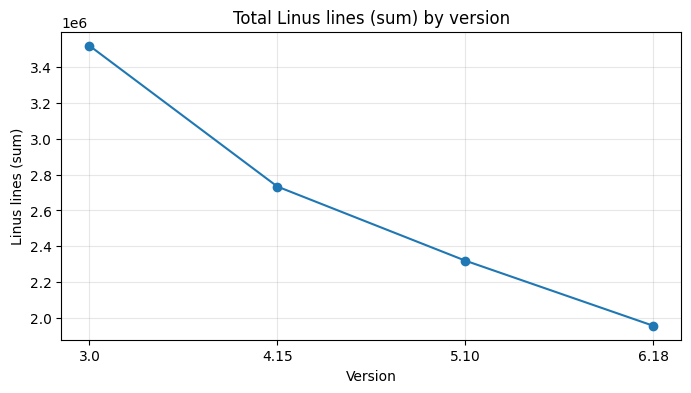

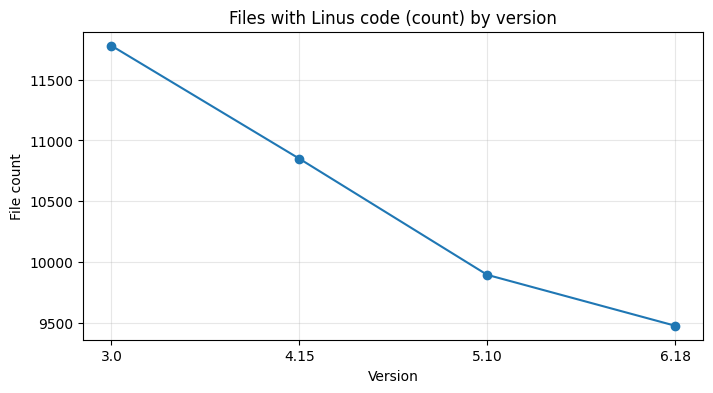

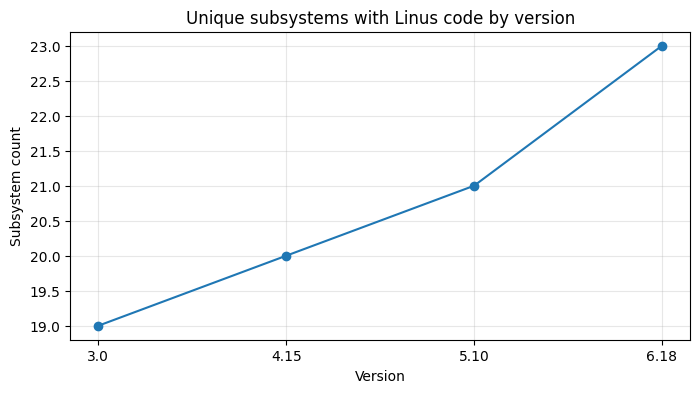

In [5]:
import matplotlib.pyplot as plt

x = list(by_version["version"])

plt.figure(figsize=(8,4))
plt.plot(x, by_version["linus_lines_sum"], marker="o")
plt.title("Total Linus lines (sum) by version")
plt.xlabel("Version")
plt.ylabel("Linus lines (sum)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(x, by_version["file_count"], marker="o")
plt.title("Files with Linus code (count) by version")
plt.xlabel("Version")
plt.ylabel("File count")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(x, by_version["unique_subsystems"], marker="o")
plt.title("Unique subsystems with Linus code by version")
plt.xlabel("Version")
plt.ylabel("Subsystem count")
plt.grid(True, alpha=0.3)
plt.show()


## 2) Распределение по подсистемам (по каждой версии)

Таблица: `version | subsystem | linus_lines_sum | file_count`


In [6]:
by_subsystem = (df.groupby(["version","subsystem"], as_index=False)
                  .agg(linus_lines_sum=("linus_lines","sum"),
                       file_count=("file_path","nunique"))
                 )

by_subsystem = by_subsystem.sort_values(
    ["version","linus_lines_sum","file_count"],
    ascending=[True, False, False],
    key=lambda s: s.map(ver_key) if s.name=="version" else s
).reset_index(drop=True)

by_subsystem.head(20)


,version,subsystem,linus_lines_sum,file_count
0,3.0,drivers,1716118,3484
1,3.0,arch,737029,4880
2,3.0,fs,346212,892
3,3.0,sound,241896,513
4,3.0,net,221787,584
5,3.0,include,152201,1027
6,3.0,scripts,21363,86
7,3.0,kernel,17841,73
8,3.0,mm,15601,39
9,3.0,security,12018,52


In [7]:
# Top-10 subsystems per version
tops = []
for v in x:
    t = by_subsystem[by_subsystem["version"]==v].head(10).copy()
    t["rank"] = range(1, len(t)+1)
    tops.append(t)
top10_subsystems = pd.concat(tops, ignore_index=True)
top10_subsystems


,version,subsystem,linus_lines_sum,file_count,rank
0,3.0,drivers,1716118,3484,1
1,3.0,arch,737029,4880,2
2,3.0,fs,346212,892,3
3,3.0,sound,241896,513,4
4,3.0,net,221787,584,5
5,3.0,include,152201,1027,6
6,3.0,scripts,21363,86,7
7,3.0,kernel,17841,73,8
8,3.0,mm,15601,39,9
9,3.0,security,12018,52,10


In [8]:
# Overall top subsystems across all versions (sum)
overall_subsystems = (df.groupby("subsystem", as_index=False)
                      .agg(linus_lines_sum=("linus_lines","sum"),
                           file_count=("file_path","nunique"),
                           versions=("version", "nunique"))
                      .sort_values(["linus_lines_sum","file_count"], ascending=False))

overall_subsystems.head(20)


,subsystem,linus_lines_sum,file_count,versions
5,drivers,5070152,5385,4
1,arch,2170449,5814,4
7,fs,1047357,1202,4
20,sound,776042,543,4
15,net,658187,655,4
8,include,415886,1325,4
13,lib,100867,101,4
18,scripts,59792,107,4
12,kernel,51668,138,4
14,mm,43155,60,4


### Визуализация: топ подсистем в каждой версии

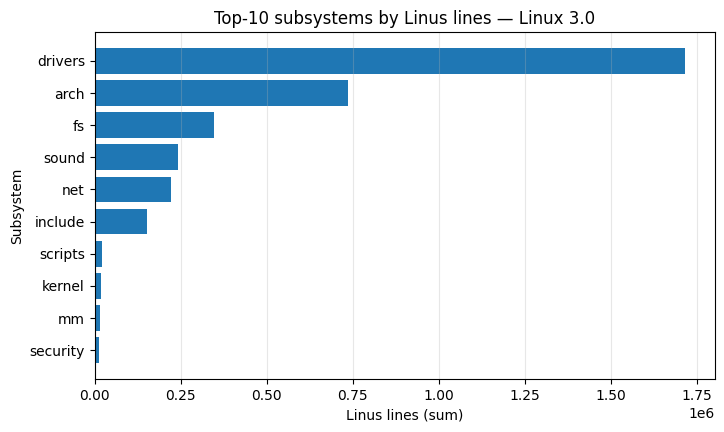

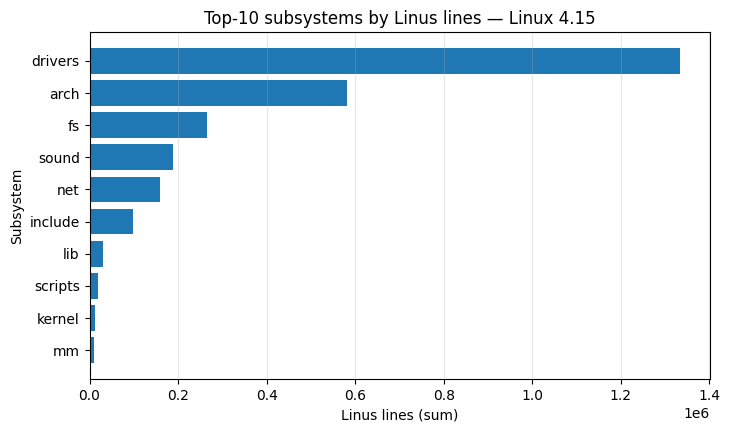

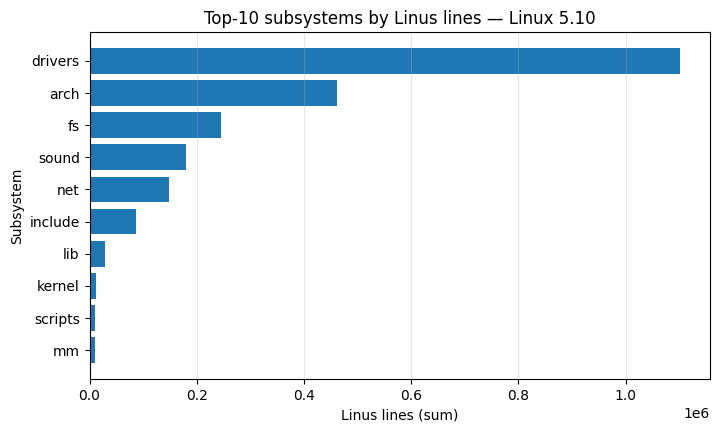

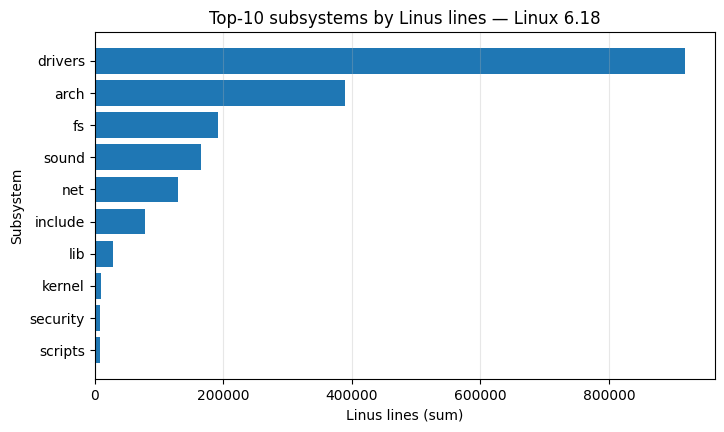

In [9]:
import numpy as np

for v in x:
    t = by_subsystem[by_subsystem["version"]==v].head(10).copy()
    t = t.sort_values("linus_lines_sum", ascending=True)
    plt.figure(figsize=(8,4.5))
    plt.barh(t["subsystem"], t["linus_lines_sum"])
    plt.title(f"Top-10 subsystems by Linus lines — Linux {v}")
    plt.xlabel("Linus lines (sum)")
    plt.ylabel("Subsystem")
    plt.grid(True, axis="x", alpha=0.3)
    plt.show()


## 3) Распределение по типам файлов (по каждой версии)

Таблица: `version | file_type | linus_lines_sum | file_count`


In [10]:
by_filetype = (df.groupby(["version","file_type"], as_index=False)
                 .agg(linus_lines_sum=("linus_lines","sum"),
                      file_count=("file_path","nunique"))
                 .sort_values(["version","linus_lines_sum","file_count"],
                              ascending=[True, False, False],
                              key=lambda s: s.map(ver_key) if s.name=="version" else s)
                 .reset_index(drop=True))

by_filetype


,version,file_type,linus_lines_sum,file_count
0,3.0,.c,2608391,5557
1,3.0,.h,593158,4523
2,3.0,.S,185951,584
3,3.0,other,93633,317
4,3.0,Kconfig,28678,236
5,3.0,Makefile,9765,561
6,4.15,.c,2021948,5521
7,4.15,.h,435844,3793
8,4.15,.S,161537,495
9,4.15,other,85450,308


### Визуализация: распределение по типам файлов

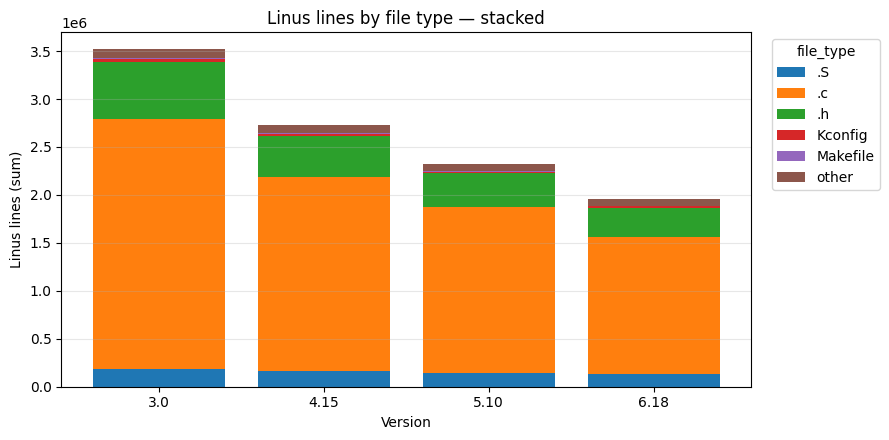

In [11]:
pivot_ft = by_filetype.pivot_table(index="version", columns="file_type", values="linus_lines_sum", aggfunc="sum").fillna(0)
pivot_ft = pivot_ft.reindex(x)

plt.figure(figsize=(9,4.5))
bottom = np.zeros(len(pivot_ft))
for col in pivot_ft.columns:
    plt.bar(pivot_ft.index, pivot_ft[col].values, bottom=bottom, label=col)
    bottom += pivot_ft[col].values

plt.title("Linus lines by file type — stacked")
plt.xlabel("Version")
plt.ylabel("Linus lines (sum)")
plt.grid(True, axis="y", alpha=0.3)
plt.legend(title="file_type", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## 5) Индекс концентрации HHI по подсистемам (по каждой версии)

**HHI (Herfindahl–Hirschman Index)** здесь измеряет, насколько вклад Линуса *сконцентрирован* в небольшом числе подсистем.

Формула для каждой версии:

\[
HHI = \sum_{s \in subsystems} (share_s)^2, \quad share_s = \frac{linus\_lines_s}{\sum linus\_lines}
\]

Интерпретация:
- ближе к **1.0** → почти всё в одной подсистеме (сильная концентрация)
- ближе к **0** → равномерно по многим подсистемам


In [ ]:
sub_share = by_subsystem.copy()

totals = sub_share.groupby("version", as_index=False)["linus_lines_sum"].sum().rename(columns={"linus_lines_sum":"total_linus_lines"})
sub_share = sub_share.merge(totals, on="version", how="left")

sub_share["share"] = sub_share["linus_lines_sum"] / sub_share["total_linus_lines"].where(sub_share["total_linus_lines"] > 0, 1)

hhi_by_version = (sub_share.groupby("version", as_index=False)
                  .agg(HHI=("share", lambda s: float((s**2).sum())),
                       total_linus_lines=("total_linus_lines","first"),
                       subsystems=("subsystem","nunique"))
                 )

hhi_by_version = hhi_by_version.sort_values("version", key=lambda s: s.map(ver_key)).reset_index(drop=True)
hhi_by_version


,version,HHI,total_linus_lines,subsystems
0,3.0,0.301955,3519576,19
1,4.15,0.302468,2733204,20
2,5.10,0.288292,2319651,21
3,6.18,0.283129,1956144,23


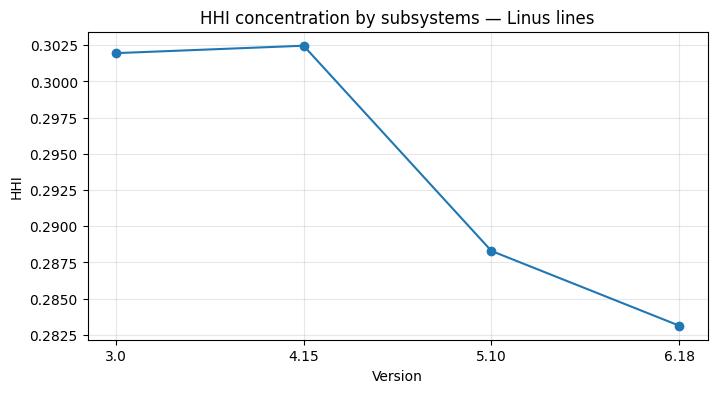

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(hhi_by_version["version"], hhi_by_version["HHI"], marker="o")
plt.title("HHI concentration by subsystems — Linus lines")
plt.xlabel("Version")
plt.ylabel("HHI")
plt.grid(True, alpha=0.3)
plt.show()


## Сравнение и итог



In [14]:
CORE = {"kernel","mm","fs","init","ipc","lib","block"}
PERIPH = {"drivers","sound","samples","tools","Documentation"}

def group_core_periph(subsystem: str) -> str:
    if subsystem in CORE:
        return "core"
    if subsystem in PERIPH:
        return "periphery"
    return "other"

df["core_group"] = df["subsystem"].map(group_core_periph)

core_vs = (df.groupby(["version","core_group"], as_index=False)
           .agg(linus_lines_sum=("linus_lines","sum"),
                file_count=("file_path","nunique"))
           .sort_values(["version","core_group"], key=lambda s: s.map(ver_key) if s.name=="version" else s))

core_vs


,version,core_group,linus_lines_sum,file_count
0,3.0,core,400045,1103
1,3.0,other,1161516,6677
2,3.0,periphery,1958015,3998
3,4.15,core,329192,1184
4,4.15,other,881340,5803
5,4.15,periphery,1522672,3863
6,5.10,core,304487,1173
7,5.10,other,733394,5175
8,5.10,periphery,1281770,3548
9,6.18,core,243753,1124


In [15]:
def pct(a, b):
    return 0.0 if b == 0 else 100.0 * (a / b)

first_v, last_v = x[0], x[-1]
bv = by_version.set_index("version")
first, last = bv.loc[first_v], bv.loc[last_v]

# Top subsystem per version
top_sub_by_ver = {}
for v in x:
    sub_df = by_subsystem[by_subsystem["version"]==v]
    if len(sub_df):
        row = sub_df.iloc[0]
        top_sub_by_ver[v] = (row["subsystem"], int(row["linus_lines_sum"]))

# core/periphery shares
core_share = {}
for v in x:
    t = core_vs[core_vs["version"]==v]
    total = int(t["linus_lines_sum"].sum())
    core_val = int(t[t["core_group"]=="core"]["linus_lines_sum"].sum())
    per_val = int(t[t["core_group"]=="periphery"]["linus_lines_sum"].sum())
    core_share[v] = (pct(core_val, total), pct(per_val, total), pct(total-core_val-per_val, total))

lines = []
lines.append(f"Versions analyzed: {', '.join(x)}")
lines.append("")
lines.append("Scale presence:")
lines.append(f"  {first_v}: files={int(first.file_count)}, linus_lines={int(first.linus_lines_sum)}, subsystems={int(first.unique_subsystems)}")
lines.append(f"  {last_v}:  files={int(last.file_count)}, linus_lines={int(last.linus_lines_sum)}, subsystems={int(last.unique_subsystems)}")
lines.append(f"  Delta {first_v}→{last_v}: "
            f"files {int(last.file_count-first.file_count):+d}, "
            f"linus_lines {int(last.linus_lines_sum-first.linus_lines_sum):+d}, "
            f"subsystems {int(last.unique_subsystems-first.unique_subsystems):+d}")
lines.append("")
lines.append("Top subsystem by Linus lines (per version):")
for v in x:
    if v in top_sub_by_ver:
        s, val = top_sub_by_ver[v]
        lines.append(f"  {v}: {s} ({val} lines)")
lines.append("")
lines.append("Core vs periphery share (by Linus lines):")
for v in x:
    c, p, o = core_share[v]
    lines.append(f"  {v}: core={c:.1f}% | periphery={p:.1f}% | other={o:.1f}%")

print("\n".join(lines))


Versions analyzed: 3.0, 4.15, 5.10, 6.18

Scale presence:
  3.0: files=11778, linus_lines=3519576, subsystems=19
  6.18:  files=9478, linus_lines=1956144, subsystems=23
  Delta 3.0→6.18: files -2300, linus_lines -1563432, subsystems +4

Top subsystem by Linus lines (per version):
  3.0: drivers (1716118 lines)
  4.15: drivers (1333912 lines)
  5.10: drivers (1101655 lines)
  6.18: drivers (918467 lines)

Core vs periphery share (by Linus lines):
  3.0: core=11.4% | periphery=55.6% | other=33.0%
  4.15: core=12.0% | periphery=55.7% | other=32.2%
  5.10: core=13.1% | periphery=55.3% | other=31.6%
  6.18: core=12.5% | periphery=55.4% | other=32.1%
